# Code to identify mis-classified points and explore their features

July 21, 2020


In [1]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import pandas as pd

import subprocess as sp
import pickle
import ipywidgets as widgets
import time


In [2]:
from sklearn.metrics import roc_curve

In [3]:
%matplotlib widget

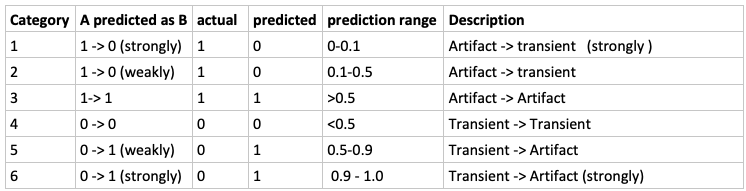
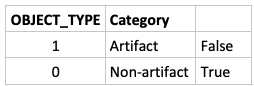

## Read test data and IDs

In [4]:
results_dir='/global/project/projectdirs/dasrepo/vpa/supernova_cnn/data/results_data/results/temp/'
results_dir='/global/project/projectdirs/dasrepo/vpa/supernova_cnn/data/results_data/results/test_with_train_data/'

In [5]:
df_preds=pd.DataFrame()
# Pick any test data, all are same
test_fname=results_dir+'ytest_3.test'
ID_fname=results_dir+'id_test_3.test'

df_preds['test']=np.loadtxt(test_fname,dtype=np.int16)
df_preds['ID']=np.loadtxt(ID_fname,dtype=np.int32)

df_preds.head()

,test,ID
0,0,11682529
1,1,7897757
2,1,6996278
3,1,7781191
4,0,10207545


### Explore misclassified points

In [6]:
## Key index  classification_index 
classification_key={1:'sig_bkg_strong',2:'sig_bkg_weak', 3:'sig_sig',4:'bkg_bkg',5:'bkg_sig_weak',6:'bkg_sig_strong'}

def f_classify_pred(series,col):
    '''
    Read in a pandas series and give category of output 1-6 for each prediction
    '''
    if   ((series.test==1.0) & (series[col]<=0.1)) : val=1
    elif ((series.test==1.0) & ((series[col]>0.1) & (series[col]<0.5))): val=2
    elif ((series.test==1.0) & (series[col]>=0.5)): val=3
    elif ((series.test==0.0) & (series[col]<=0.5)): val=4
    elif ((series.test==0.0) & ((series[col]<0.9) & (series[col]>0.5))): val=5
    elif ((series.test==0.0) & (series[col]>=0.9)) : val=6

    else: raise SystemError
    
    return val


In [7]:
for model_num in ([3,8,9,16]):
    col='m_'+str(model_num)
    fname=results_dir+'ypred_{0}.test'.format(model_num)
    df_preds[col]=np.loadtxt(fname)

    pred_class=df_preds.apply(lambda row: f_classify_pred(row,col),axis=1).values
    df_preds['pred_'+col]=pred_class ## Add pred_class as a new column


In [8]:
# df_rf=pd.read_csv(fname)
# print(df_rf.shape)
# df_rf.hist(column='score')

### Read random forest results

In [9]:
### Read Random forest results
fname='/global/cfs/cdirs/dasrepo/vpa/supernova_cnn/data/autoscan_data/results/random-forest_scores.csv'
df_rf=pd.read_csv(fname)
# Slice on the ID values in test dataset
df_rf=df_rf[df_rf['run_id'].isin(df_preds.ID.values)]

df_rf=df_rf.rename(columns={'score':'m_rf','run_id':'ID'})
df_rf['m_rf']=(1.0-df_rf['m_rf'])  ## flipping 0->1 and 1-> 0
# Merge dataframes on ID column 
df_preds=df_preds.merge(df_rf,on='ID')

### Compute predictions for Random forest results
col='m_rf'
pred_class=df_preds.apply(lambda row: f_classify_pred(row,col),axis=1).values
new_col='pred_'+col
df_preds[new_col]=pred_class

In [10]:
df_preds.hist(column='m_rf',bins=20)

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x2aaadef9fb70>]],
      dtype=object)

In [11]:
# df_preds.hist(column='pred_m_8',bins=20)
df_preds.hist(column='pred_m_rf',bins=20)

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x2aaadf18cd30>]],
      dtype=object)

In [12]:
df_preds.head(20)

,test,ID,m_3,pred_m_3,m_8,pred_m_8,m_9,pred_m_9,m_16,pred_m_16,m_rf,pred_m_rf
0,0,11682529,0.278793,4,0.037110,4,0.009231,4,0.079252,4,0.170,4
1,1,7897757,0.984071,3,0.999564,3,0.999638,3,0.981876,3,0.940,3
2,1,6996278,0.999379,3,0.999744,3,0.999512,3,0.998986,3,1.000,3
3,1,7781191,0.998863,3,0.990101,3,0.999909,3,0.999328,3,0.980,3
4,0,10207545,0.004526,4,0.015051,4,0.000763,4,0.000425,4,0.000,4
5,0,11483940,0.042929,4,0.059861,4,0.015139,4,0.017488,4,0.255,4
6,1,8032995,0.998829,3,0.999971,3,0.999583,3,0.999950,3,1.000,3
7,1,10045930,0.993357,3,0.991055,3,0.999950,3,0.993081,3,1.000,3
8,1,11142639,0.992257,3,0.995673,3,0.999840,3,0.987221,3,1.000,3
9,0,11585389,0.000217,4,0.000039,4,0.001364,4,0.001030,4,0.000,4


## Histograms

In [13]:
df=df_preds.copy()

In [14]:
# df

In [15]:
### Proportion of models in each category
for i in np.unique(df.pred_m_3.values):
    print(i,df[df.pred_m_3==i].shape[0]/df.shape[0])

1 0.0014238675803150307
2 0.005595354632019222
3 0.48770801815431164
4 0.4919351250333719
5 0.008876924446026519
6 0.004460710153955682


In [16]:
## Histogram of signal points strongly mis-classified as background
def f_hist_compare(df,col1,value):
    
    col_list=[ i for i in df.columns.values if i[:4]=='pred']
    cols=[col for col in col_list if col != col1] # Pick columns except the one used to splice df
    
    df[df[col1]==value].plot(kind='hist',y=cols,subplots=True,grid=True,bins=12)
    print('Total points in category',df[df[col1]==value].shape[0])

f_hist_compare(df,'pred_m_3',1)


Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

Total points in category 128


In [17]:
## misclassified points for all models
df[(df.pred_m_3==1)&(df.pred_m_8==1)&(df.pred_m_16==1)&(df.pred_m_9==1)].shape

(15, 12)

In [18]:
df.head()

,test,ID,m_3,pred_m_3,m_8,pred_m_8,m_9,pred_m_9,m_16,pred_m_16,m_rf,pred_m_rf
0,0,11682529,0.278793,4,0.037110,4,0.009231,4,0.079252,4,0.17,4
1,1,7897757,0.984071,3,0.999564,3,0.999638,3,0.981876,3,0.94,3
2,1,6996278,0.999379,3,0.999744,3,0.999512,3,0.998986,3,1.00,3
3,1,7781191,0.998863,3,0.990101,3,0.999909,3,0.999328,3,0.98,3
4,0,10207545,0.004526,4,0.015051,4,0.000763,4,0.000425,4,0.00,4


In [19]:
### Prediction histograms

def f_hist_predictions(column='m_3'):
    sig_preds=df[df.test==1][column].values
    bkg_preds=df[df.test==0][column].values
#     plt.figure()
    # plt.hist(sig_preds,bins=10,alpha=0.5,color='y')
    # plt.hist(bkg_preds,bins=10,alpha=0.5,color='b')
    plt.hist([sig_preds,bkg_preds],bins=20,alpha=0.5,label=[column+':sig=1',column+':bkg=0'])
    plt.legend()
    

plt.figure()
f_hist_predictions(column='m_rf')
plt.figure()
f_hist_predictions(column='m_9')

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

## Plot roc curve

####The ROC curve flip argument

Since True=1 in keras, but Non-Artifact is defined as 0 in the paper, 
Tp <-> Tn and Fn <-> Fp

Actual roc curve is x=mdr, y=fpr


mdr=Fn/(Tp+Fn) -> Fp/(Tn+Fp) = fpr
fpr=Fp/(Tn+Fp) -> Fn/(Tp+Fn) = mdr = fnr = 1-tpr


Hence we get an mdr <-> fpr flip


In [20]:
df=df_preds.copy()

In [21]:
def f_roc(df,col,label):
#     fpr,tpr,threshold=roc_curve(y_test,y_pred)
    fpr,tpr,threshold=roc_curve(df.test,df[col],pos_label=None)

    x,y=1-tpr,fpr 
    # The roc curve flip
    
    x,y=fpr,(1-tpr)
    
#     plt.figure()
    plt.plot(x, y,linestyle='',label=label,markersize=2,marker='*')
    
#     plt.plot(fpr,color='r',label='fpr')
#     plt.plot(tpr,color='b',label='tpr')
# #     plt.plot((1-tpr),color='y',label='mdr')  ### mdr=1-tpr
#     plt.plot(threshold[1:],label='threshold')
    # ### Reference points in mdr plot in paper
    plt.plot(0.03,0.038,marker='s',markersize=8,color='k')
    plt.plot(0.04,0.024,marker='s',markersize=8,color='k')
    plt.plot(0.05,0.016,marker='s',markersize=8,color='k')

    plt.xlabel('MDR')
    plt.ylabel('FPR')
    plt.xlim(0,0.1)
    plt.ylim(0,0.05)
    print(threshold)



### roc curve with all points dropped 
col='m_3'
plt.figure()
f_roc(df,col,'raw')
f_roc(df[(df.pred_m_3!=6)],col,'drop bkg-sig')
f_roc(df[(df.pred_m_3!=1)],col,'drop sig-bkgnd')
f_roc(df[(df.pred_m_3!=1)&(df.pred_m_3!=6)],col,'drop-both')
# f_roc(df[(df.pred_m_3!=5)],col,'drop-weak-bkg-sig')
# f_roc(df[(df.pred_m_3!=2)],col,'drop-weak-sig-bkg')

plt.legend()

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

[2.00000000e+00 1.00000000e+00 9.99999881e-01 ... 8.34465027e-07
 7.45058060e-07 1.49011612e-07]
[2.00000000e+00 1.00000000e+00 9.99999881e-01 ... 8.34465027e-07
 7.45058060e-07 1.49011612e-07]
[2.00000000e+00 1.00000000e+00 9.99999881e-01 ... 8.34465027e-07
 7.45058060e-07 1.49011612e-07]
[2.00000000e+00 1.00000000e+00 9.99999881e-01 ... 8.34465027e-07
 7.45058060e-07 1.49011612e-07]


In [22]:
### Roc curve for Random forest
plt.figure()
f_roc(df,'m_3','model 3')
f_roc(df,'m_16','model 8')
f_roc(df,'m_rf','Random forest')
plt.legend()

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

[2.00000000e+00 1.00000000e+00 9.99999881e-01 ... 8.34465027e-07
 7.45058060e-07 1.49011612e-07]
[2.00000000e+00 1.00000000e+00 9.99999940e-01 ... 2.38418579e-07
 2.08616257e-07 2.98023224e-08]
[2.00000000e+00 1.00000000e+00 9.98571429e-01 ... 2.00000000e-03
 1.66666667e-03 0.00000000e+00]


In [23]:
### roc ruve with 50% points dropped 
def f_get_frac_points(df,col,val,frac=0.50):
    # Get fraction of points belonging to category val from df, for column col

    a=df[df[col]!=val]
    b=df[df[col]==val].sample(frac=frac)
    df1=a.append(b)

    return df1

dfa=f_get_frac_points(df,'pred_m_3',6,0.5)
dfb=f_get_frac_points(df,'pred_m_3',1,0.5)
## Both 
dfc=pd.concat([dfa[dfa['pred_m_3']!=1],dfb[dfb['pred_m_3']!=6]]).drop_duplicates().reset_index(drop=True)
print(df.shape,dfa.shape,dfb.shape,dfc.shape)


col='m_3'
plt.figure()
f_roc(df,col,'raw')
f_roc(dfa,col,'drop 6: bkg-sig-50pct')
f_roc(dfb,col,'drop 1: sig-bkg-50pct')
f_roc(dfc,col,'drop both')
plt.legend()


(89896, 12) (89695, 12) (89832, 12) (89631, 12)


Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

[2.00000000e+00 1.00000000e+00 9.99999881e-01 ... 8.34465027e-07
 7.45058060e-07 1.49011612e-07]
[2.00000000e+00 1.00000000e+00 9.99999881e-01 ... 8.34465027e-07
 7.45058060e-07 1.49011612e-07]
[2.00000000e+00 1.00000000e+00 9.99999881e-01 ... 8.34465027e-07
 7.45058060e-07 1.49011612e-07]
[2.00000000e+00 1.00000000e+00 9.99999881e-01 ... 8.34465027e-07
 7.45058060e-07 1.49011612e-07]


### View strongly misclassified images

In [ ]:
def f_plot_grid(arr,cols=16,fig_size=(15,5)):
    ''' Plot a grid of images
    '''
    size=arr.shape[0]    
    rows=int(np.ceil(size/cols))
    print(rows,cols)

    fig,axarr=plt.subplots(rows,cols,figsize=fig_size, gridspec_kw = {'wspace':0, 'hspace':0})
    if rows==1: axarr=np.reshape(axarr,(rows,cols))
    if cols==1: axarr=np.reshape(axarr,(rows,cols))
    
    for i in range(min(rows*cols,size)):
        row,col=int(i/cols),i%cols
        try: 
            axarr[row,col].imshow(arr[i],origin='lower',  extent = [0, 128, 0, 128])
        # Drop axis label
        except Exception as e:
            print('Exception:',e)
            pass
        temp=plt.setp([a.get_xticklabels() for a in axarr[:-1,:].flatten()], visible=False)
        temp=plt.setp([a.get_yticklabels() for a in axarr[:,1:].flatten()], visible=False)
    

In [ ]:
### Extract file name
f2='/global/project/projectdirs/dasrepo/vpa/supernova_cnn/data/gathered_data/summary_label_files.csv'
df2=pd.read_csv(f2,sep=',',comment='#')
# df2.head(20)

In [ ]:
# fig=plt.figure()
#     # Plot training & validation accuracy values

# for count1,iD in enumerate(IDs[:1]):
#     for count2,key in enumerate(keys):
#         print(iD,key)
#         df_temp=df3[(df3.ID==iD)&(df3.filename.str.startswith(key))]
#         fle=df_temp['file path'].values[0]
#         img=plt.imread(fle)
# #         display(df_temp)
#         idx1,idx2=count1+1,count2+1
#         print(idx1,idx2)
#         fig.add_subplot(idx1*idx2,idx1,idx2)
#         plt.imshow(img)


In [ ]:
df_preds.shape

In [ ]:
category=6
num_images=100

IDs=df_preds[df_preds.pred_m_3==category].ID.values
print(IDs.shape)
np.random.shuffle(IDs)
IDs=IDs[:num_images]

df3=df2[df2.ID.isin(IDs)]
df3.shape
# del(df2)


keys=['temp','srch','diff']
img=np.array([plt.imread(df3[(df3.ID==iD)&(df3.filename.str.startswith(key))]['file path'].values[0]) for iD in IDs for key in keys ])
print(img.shape)
df3.head()

In [ ]:
# [(iD,key) for iD in IDs[:10] for key in keys ]

In [ ]:
# f_plot_grid(img,cols=9,fig_size=(9,5))
t1=time.time()
f_plot_grid(img,cols=3,fig_size=(3,100))
fname='category{0}.pdf'.format(str(category))
plt.savefig(fname)
plt.close()
t2=time.time()
print(t2-t1)


In [ ]:
df_merged.columns

In [ ]:
df_merged[df_merged.ID.isin(IDs)][['OBJECT_TYPE','m_3','pred_m_3']]

### View features of misclassified points

In [ ]:
### Get features of IDs of test dataset
f2='/global/project/projectdirs/dasrepo/vpa/supernova_cnn/data/gathered_data/autoscan_features.3.csv'
df_features=pd.read_csv(f2,sep=',',comment='#')
df_features=df_features[df_features.ID.isin(df.ID.values)]


In [ ]:
df.head(5)
# pd.concat([df.set_index('ID'),df_features.set_index('ID')],join='outer').reset_index()
df_merged=pd.merge(df,df_features,on='ID')

In [ ]:
df=df_merged[df_merged.pred_m_3==1]

In [ ]:
def f_plot_col(df,xcol,ycol='pred_m_3'):
    df.plot(x=xcol,y=ycol,kind='line',linestyle='',marker='*',color='r')



In [ ]:
cols=['OBJECT_TYPE','AMP', 'A_IMAGE',
       'A_REF', 'BAND', 'B_IMAGE', 'B_REF', 'CCDID', 'COLMEDS', 'DIFFSUMRN',
       'ELLIPTICITY', 'FLAGS', 'FLUX_RATIO', 'GAUSS', 'GFLUX', 'L1',
       'LACOSMIC', 'MAG', 'MAGDIFF', 'MAGLIM', 'MAG_FROM_LIMIT', 'MAG_REF',
       'MAG_REF_ERR', 'MASKFRAC', 'MIN_DISTANCE_TO_EDGE_IN_NEW', 'N2SIG3',
       'N2SIG3SHIFT', 'N2SIG5', 'N2SIG5SHIFT', 'N3SIG3', 'N3SIG3SHIFT',
       'N3SIG5', 'N3SIG5SHIFT', 'NN_DIST_RENORM', 'NUMNEGRN', 'SCALE', 'SNR',
       'SPREADERR_MODEL', 'SPREAD_MODEL']

### Selected columns 
cols=['AMP','A_REF','B_IMAGE', 'B_REF', 'COLMEDS', 'DIFFSUMRN','ELLIPTICITY', 
          'L1', 'SCALE', 'SPREADERR_MODEL', 'SPREAD_MODEL']
widgets.interact(f_plot_col,df=widgets.fixed(df_merged),xcol=widgets.ToggleButtons(options=cols,disabled=False))

In [ ]:
# widgets.interact(f_plot_col,df=widgets.fixed(df_merged),xcol=widgets.SelectionSlider(options=cols,disabled=False))